# Tutorial: Retrieve Electric and Magnetic Fields

In this example we will calculate the electric and magnetic fields from a metamaterial using S$^4$

## Table of contents:

* [Visualizing 2D and 3D functions](#visualizing)
    * [meshgrid](#meshgrid)
    * [Reverse Indexing](#reverse)
    * [multivariate function](#multivariate)
* [Simulation](#simulation)
    * [Helper functions](#helper)
    * [Visualizing the fields](#field_viz)
    * [Verify Data Structure](#data_structure)
* [Periodic Boundary Conditions](#PBC)
    * [Exercise](#exercise)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np

from itertools import product

import S4

# First, an aside: visualizing 2D and 3D functions <a class="anchor" id="visualizing"></a>

When we are visualizing these fields, we have a bit of a problem because we have a vector function of multivariables:

$$ \vec{E}, \vec{H} = f\left(x, y, z\right) = f\left(\vec{x}\right) $$

Why is this a problem? *Because it is hard to visualize*. We have $3$ spatial dimensions as well as the *3* dimensions of the output vector. The best we can intuitively visualize is $4$ (A 3D plot with color indicating a value of the 4th), although we could probably exceed this by including arrows (although that would be difficult to visualize depending on the camera viewpoint).

To demonstrate this, let's start with a simple multivariate function:

$$ Z\left(x, y\right) = f\left(x, y\right) = \cos{x} \cdot sin{y} $$

In [61]:
# create the function and plot it
# initialize x, y inputs
x = np.arange(0, 2*np.pi, 0.1)
y = np.arange(0, 2*np.pi, 0.1)
# convert to the meshgrid form
X, Y = np.meshgrid(x, y)
# compute Z
Z = np.cos(Y) * np.sin(Y)

## ok, what's this meshgrid and what does it do? <a class="anchor" id="meshgrid"></a>

great question. First, let's look at x and y

In [3]:
print("x")
print(x)
print(x.shape)
print("y")
print(y)
print(y.shape)

x
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2]
(63,)
y
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2]
(63,)


and now X, Y

In [4]:
print("X")
print(X)
print(X.shape)
print("Y")
print(Y)
print(Y.shape)

X
[[0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 ...
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]]
(63, 63)
Y
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.2 0.2 0.2 ... 0.2 0.2 0.2]
 ...
 [6.  6.  6.  ... 6.  6.  6. ]
 [6.1 6.1 6.1 ... 6.1 6.1 6.1]
 [6.2 6.2 6.2 ... 6.2 6.2 6.2]]
(63, 63)


### What do we see?

the `X` array has `x` running *across* (in each row) while the `Y` array has `y` running *down* (in each column). 

### Physically, what does this mean?

We want to compute the value of $Z$ from $0 \leq x \leq 2\pi, 0 \leq y \leq 2\pi$. Because $Z = f\left(x, y\right)$, we need the value of x and y at each point we want to compute: we break this interval into $\Delta=0.1$ intervals and compute at each `x` and `y`. A *naive* approach would look like:

```python
for x in np.arange(0, 2*np.pi, 0.1):
    for y in np.arange(0, 2*np.pi, 0.1):
        z = np.cos(x) * np.sin(y)function
```

**NOTE:** this purposefully neglects indexing into Z, something we will address momentarily

Because using built-in NumPy vectorization is fast and using for loops is slow, we want to do this in a more efficient manner. First, we know that we can do the following:

$$ f_i \left(x\right) = \cos{x_i} \rightarrow f\left(\vec{x}\right) = \cos{\vec{x}}$$

or, in code

In [5]:
# %%timeit
# uncomment to see the performance
# also, comment out the print statements:
# major time sink

x = np.arange(0, 2*np.pi, 0.1)
z = np.zeros(shape=x.shape)
for i in range(x.shape[0]):
    z[i] = np.cos(x[i])
print(z)
out_str = "68.6 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)"
print(out_str)

[ 1.          0.99500417  0.98006658  0.95533649  0.92106099  0.87758256
  0.82533561  0.76484219  0.69670671  0.62160997  0.54030231  0.45359612
  0.36235775  0.26749883  0.16996714  0.0707372  -0.02919952 -0.12884449
 -0.22720209 -0.32328957 -0.41614684 -0.5048461  -0.58850112 -0.66627602
 -0.73739372 -0.80114362 -0.85688875 -0.90407214 -0.94222234 -0.97095817
 -0.9899925  -0.99913515 -0.99829478 -0.98747977 -0.96679819 -0.93645669
 -0.89675842 -0.84810003 -0.79096771 -0.7259323  -0.65364362 -0.57482395
 -0.49026082 -0.40079917 -0.30733287 -0.2107958  -0.11215253 -0.01238866
  0.08749898  0.18651237  0.28366219  0.37797774  0.46851667  0.55437434
  0.63469288  0.70866977  0.77556588  0.83471278  0.88551952  0.92747843
  0.96017029  0.98326844  0.9965421 ]
68.6 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [6]:
# %%timeit
# uncomment to see the performance
# also, comment out the print statements:
# major time sink

x = np.arange(0, 2*np.pi, 0.1)
z = np.cos(x)
print(z)
out_str = "1.9 µs ± 27.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)"
print(out_str)

[ 1.          0.99500417  0.98006658  0.95533649  0.92106099  0.87758256
  0.82533561  0.76484219  0.69670671  0.62160997  0.54030231  0.45359612
  0.36235775  0.26749883  0.16996714  0.0707372  -0.02919952 -0.12884449
 -0.22720209 -0.32328957 -0.41614684 -0.5048461  -0.58850112 -0.66627602
 -0.73739372 -0.80114362 -0.85688875 -0.90407214 -0.94222234 -0.97095817
 -0.9899925  -0.99913515 -0.99829478 -0.98747977 -0.96679819 -0.93645669
 -0.89675842 -0.84810003 -0.79096771 -0.7259323  -0.65364362 -0.57482395
 -0.49026082 -0.40079917 -0.30733287 -0.2107958  -0.11215253 -0.01238866
  0.08749898  0.18651237  0.28366219  0.37797774  0.46851667  0.55437434
  0.63469288  0.70866977  0.77556588  0.83471278  0.88551952  0.92747843
  0.96017029  0.98326844  0.9965421 ]
1.9 µs ± 27.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


That is a huge speedup (36x)! If we can avoid using `for` loops, we absolutely should.

As we previously mentioned, we need to do this over both `x` and `y` (a double-nested for loop). This brings us back to the meshgrid command:

In [7]:
print("X")
print(X)
print(X.shape)
print("Y")
print(Y)
print(Y.shape)

X
[[0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 ...
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]]
(63, 63)
Y
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.2 0.2 0.2 ... 0.2 0.2 0.2]
 ...
 [6.  6.  6.  ... 6.  6.  6. ]
 [6.1 6.1 6.1 ... 6.1 6.1 6.1]
 [6.2 6.2 6.2 ... 6.2 6.2 6.2]]
(63, 63)


We'll cheat a little bit and use the `imshow` command to view these and gain an intuition about how these work and what we're seeing 

<IPython.core.display.Javascript object>


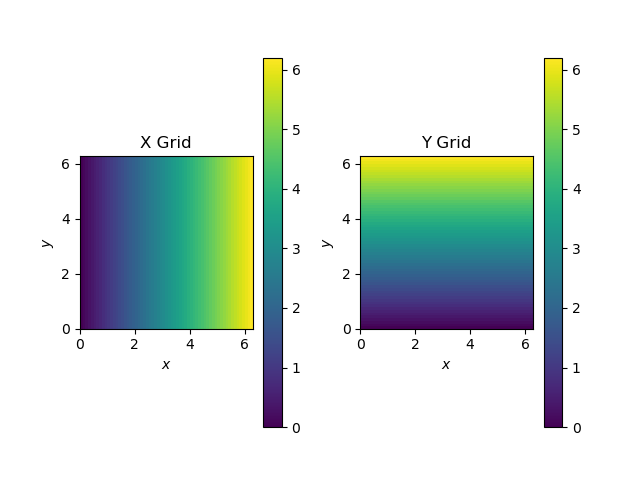

In [8]:
fig = plt.figure()
im_arr = [X, Y]
title_arr = ["X Grid", "Y Grid"]
for i, im in enumerate(im_arr):
    # we are adding subplot i to an array of plots
    # with 1 row, 2 columns (note: need base-1 indexing)
    ax = fig.add_subplot(1, 2, i+1)
    l_obj = ax.imshow(im, origin="lower",
                      extent=[0, 2*np.pi, 0, 2*np.pi])
    fig.colorbar(l_obj, ax=ax)
    ax.set_title(title_arr[i])
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
plt.subplots_adjust(wspace=0.3)
plt.show()

Notice how the values for `X` increase as `x` increases, but not as `y` increases, and vice versa

### This next bit is super important and also super easy to mess up, SO **PAY ATTENTION**

Let's recall `X` and `Y` again:

In [40]:
print("X")
print(X)
print(X.shape)
print("Y")
print(Y)
print(Y.shape)

X
[[0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 ...
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]
 [0.  0.1 0.2 ... 6.  6.1 6.2]]
(63, 63)
Y
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.2 0.2 0.2 ... 0.2 0.2 0.2]
 ...
 [6.  6.  6.  ... 6.  6.  6. ]
 [6.1 6.1 6.1 ... 6.1 6.1 6.1]
 [6.2 6.2 6.2 ... 6.2 6.2 6.2]]
(63, 63)


Now, recall that for a matrix $X$ an individual element is given by its *row* then *column* or

$$ x = X_{r,c} $$

So, if we want to look at the first row of `X`

In [9]:
print(X[0])

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2]


We get back what we would expect. If we look at the first column:

In [10]:
print(X[:,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


We also get back what we expect.

### This next bit is super important and also super easy to mess up, SO PAY ATTENTION <a class="anchor" id="reverse"></a>

**This means that the order of indexing into the function and into the array are reversed!**

Let:

$$ f_{idx} \left(x\right) = \arg \left(x == f\right) $$

$$ Z_{r, c} = Z_{y_{idx}, x_{idx}} = z\left(x, y\right) $$

We can demonstrate this with the following bit of naive code that attempts to reproduce the X mesh

In [11]:
X_wrong = np.zeros(shape=(len(x), len(y)))
Y_wrong = np.zeros(shape=(len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        X_wrong[i, j] = x[i]
        Y_wrong[i, j] = y[j]

<IPython.core.display.Javascript object>


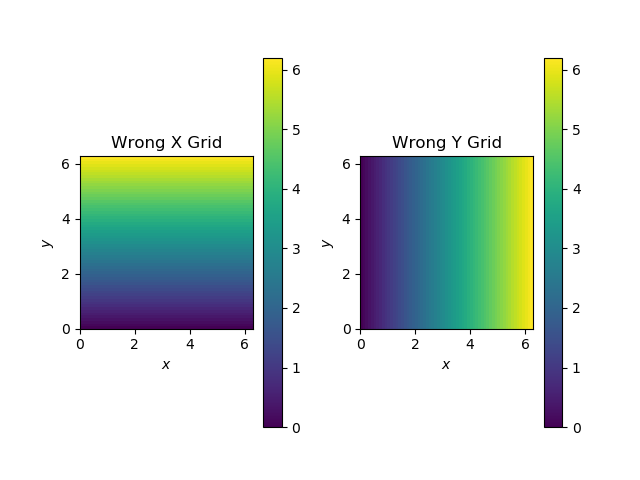

In [12]:
fig = plt.figure()
im_arr = [X_wrong, Y_wrong]
title_arr = ["Wrong X Grid", "Wrong Y Grid"]
for i, im in enumerate(im_arr):
    # we are adding subplot i to an array of plots
    # with 1 row, 2 columns (note: need base-1 indexing)
    ax = fig.add_subplot(1, 2, i+1)
    l_obj = ax.imshow(im, origin="lower",
                      extent=[0, 2*np.pi, 0, 2*np.pi])
    fig.colorbar(l_obj, ax=ax)
    ax.set_title(title_arr[i])
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
plt.subplots_adjust(wspace=0.3)
plt.show()

### and now we do it the correct way

In [13]:
X_correct = np.zeros(shape=(len(x), len(y)))
Y_correct = np.zeros(shape=(len(x), len(y)))
for j in range(len(y)):
    for i in range(len(x)):
        X_correct[j, i] = x[i]
        Y_correct[j, i] = y[j]

<IPython.core.display.Javascript object>


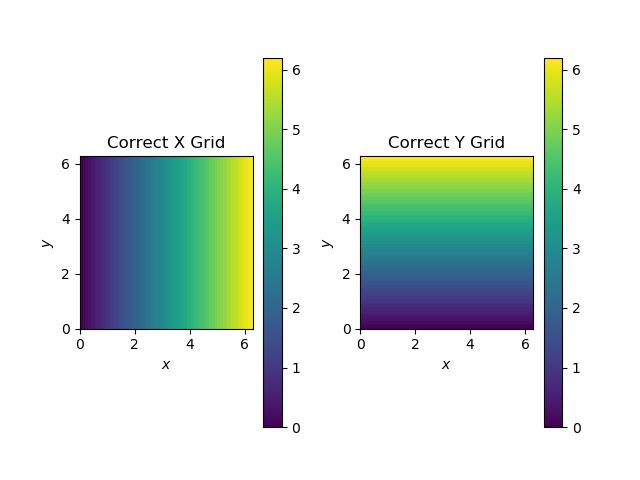

In [14]:
fig = plt.figure()
im_arr = [X_correct, Y_correct]
title_arr = ["Correct X Grid", "Correct Y Grid"]
for i, im in enumerate(im_arr):
    # we are adding subplot i to an array of plots
    # with 1 row, 2 columns (note: need base-1 indexing)
    ax = fig.add_subplot(1, 2, i+1)
    l_obj = ax.imshow(im, origin="lower",
                      extent=[0, 2*np.pi, 0, 2*np.pi])
    fig.colorbar(l_obj, ax=ax)
    ax.set_title(title_arr[i])
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
plt.subplots_adjust(wspace=0.3)
plt.show()

## Back to the multivariate function <a class="anchor" id="multivariate"></a>

Let's compute and plot Z

In [15]:
def our_func(x, y):
    return np.cos(x) * np.sin(y)

Z = our_func(X, Y)

<IPython.core.display.Javascript object>


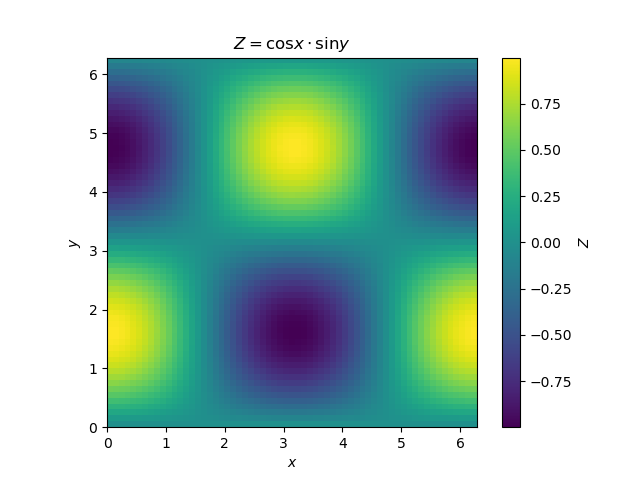

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
l_obj = ax.imshow(Z, origin="lower",
                  extent=[0, 2*np.pi, 0, 2*np.pi])
cbar = fig.colorbar(l_obj, ax=ax)
cbar.set_label("$Z$")
ax.set_title("$Z=\cos{x} \cdot \sin{y}$")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
plt.show()

# Now to simulate and render a real system <a class="anchor" id="simulation"></a>

Now that we understand that, we can start to handle our real system.

We will be simulating silicon cylinders growing out from a silicon slab.

We want to be able to visualize the electric and magnetic fields associated with this new geometry.

We will be computing the electric and magnetic fields, $\vec{E}, \vec{H}$, both of which are complex vectors:

$$\vec{E}\left(x, y, z\right) = \left((a + bi)\hat{x}, (c + di)\hat{y}, (e + fi)\hat{z}\right)$$
$$\vec{H}\left(x, y, z\right) = \left((a + bi)\hat{x}, (c + di)\hat{y}, (e + fi)\hat{z}\right)$$

We need to create a data structure to store this data and access it later. We will build it from the bottom up. We know that each component of $\vec{E}, \vec{H}$ is complex, and thus needs to be of type `np.complex128`. We know that these complex components form vectors in $\mathbb{R}^3$ *ie* 3-vectors. We know that there is one of these complex 3-vectors at every point we sample in $\mathbb{R}^3$. We thus need an array of the form

$$\vec{E}_{z_{idx}, y_{idx}, x_{idx}} = \left((a + bi)\hat{x}, (c + di)\hat{y}, (e + fi)\hat{z}\right)$$

or as code

```python
e_field = np.zeros(shape=(n_z, n_y, n_x, 3), dtype=np.complex128)
```

**NOTE:** we maintain the "reversed" indexing. While you could index `e_field[y_idx, x_idx, z_idx]` this would arguably be more confusing.

Let's begin by simulating both a patterned and unpatterned material and compare them

## create helper functions <a class="anchor" id="helper"></a>

We will create a few helper functions for both automation and ease of understanding

In [17]:
def create_simulation(Lx, Ly, r, x0, y0):
    """
    Create a new S4 simulation object.
    
    Note that we do not pattern the device in this function.
    
    Returns:
    
        S: S4 Simulation object
    """
    S = S4.Simulation()
    S.create_new()

    S.set_lattice([[Lx, 0.0], [0.0, Ly]])
    S.set_num_g(27)

    S.add_material("Silicon", [12.0, 0.0])
    S.add_material("Vacuum", [1.0, 0.0])

    S.add_layer("AirAbove", 0.0, "Vacuum")

    S.add_layer("Slab", 0.5, "Vacuum")

    S.add_layer("SiBelow", 0.0, "Silicon")

    S.set_excitation_planewave([0.0, 0.0], [0.0, 0.0], [1.0, 0.0])

    S.set_frequency(0.6306178089044143)
    
    return S

def create_circles(S, layer, material, centers, radii):
    """
    Arguments:
    
        S: S4 Simulation Object
        layer: layer to pattern
        material: material to create pattern
        centers: list of [x, y] coordinates specifying the centers of the circles
        radii: list of radii to pattern. Must be equal and paired with the centers
    """
    for (center, radius) in zip(centers, radii):
        S.set_layer_pattern_circle(layer, material, center, radius)

## simulate a single layer

In this case we will be creating the field data structure to have a shape

```python
e_field = np.zeros(shape=(n_y, n_x, 3), dtype=np.complex128)
```

In [55]:
# set up device geometry
# lattice spacing
Lx = 1.0
Ly = 1.0
# radius and center
r = 0.2
x0 = 0.0
y0 = 0.0
# simulate the unpatterned surface
S = create_simulation(Lx, Ly, r, x0, y0)
# set the simulation parameters
z = 0.0
n_x = 200
n_y = 200
# obtain the electric and magnetic fields
e_field_plane, h_field_plane = S.get_field_plane(z, (n_x, n_y))
# reshape into the correct array size (it is returned "flat")
# so n_y * n_x * 3 -> (n_y, n_x, 3)
e_field_plain = np.copy(e_field_plane.reshape((n_y, n_x, 3)))
h_field_plain = np.copy(h_field_plane.reshape((n_y, n_x, 3)))

# create the simulation object
S = create_simulation(Lx, Ly, r, x0, y0)
# define the centers of our metasurface
centers = [[x0, y0]]
radii = [r for _ in centers]
create_circles(S, "Slab", "Silicon", centers, radii)
# set the simulation parameters
z = 0.0
n_x = 200
n_y = 200
# obtain the electric and magnetic fields
e_field_plane, h_field_plane = S.get_field_plane(z, (n_x, n_y))
# reshape into the correct array size (it is returned "flat")
# so n_y * n_x * 3 -> (n_y, n_x, 3)
e_field_plane = np.copy(e_field_plane.reshape((n_y, n_x, 3)))
h_field_plane = np.copy(h_field_plane.reshape((n_y, n_x, 3)))

# visualize the fields <a class="anchor" id="field_viz"></a>

Let's start by visualizing the x, y, and z components of the $\vec{E}$ field:

$$ f = \left|\vec{x}\right|, \left|\vec{y}\right|, \left|\vec{z}\right| $$

<IPython.core.display.Javascript object>


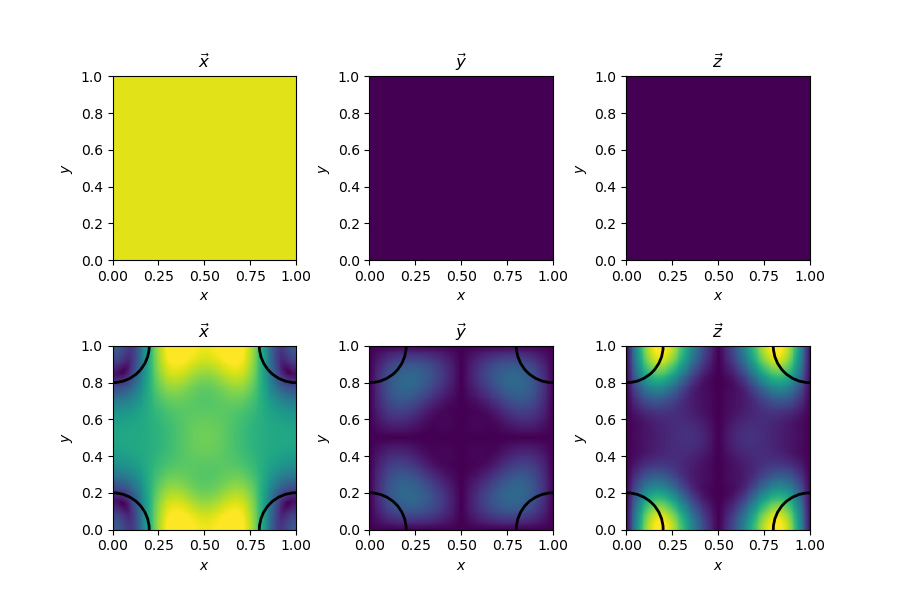

In [60]:
# create array to hold component labels
title_arr = ["x", "y", "z"]
field_arr = [e_field_plain, e_field_plane]
# create plot
fig = plt.figure(figsize=(9, 6))
cnt = 1
for i in range(2):
    l_field = field_arr[i]
    for j in range(3):
        # add the subplot
        ax = fig.add_subplot(2, 3, cnt)
        # show the image
        # note we use "lower" to ensure the origin is in the lower left
        # rather than the upper left
        # we also explicitly set the extent, or the domain of
        # the x and y coordinates
        ax.imshow(np.abs(l_field[:,:,j]),
                  origin="lower",
                  extent=[0, Lx, 0, Ly],
                  vmin=0.0,
                  vmax=1.5)
        # set title and labels
        title_str = "\\vec{" +  title_arr[j] + "}"
        ax.set_title("${}$".format(title_str))
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        # create an array to hold all the centers of the cylinders
        # we do this in this way to account for the periodic boundary conditions
        # we will come back to this in a bit to show how we can alter this
        # also note I am using list comprehension split over multiple
        # lines for readability
        if i == 1:
            p_centers = [np.array(centers[i]) + np.array(d)
                         for d in product([0.0, Lx], [0.0, Ly])
                         for i in range(len(centers))]
            # this is a bit cumbersome but it seems to work just fine
            # draw the circles
            for center in p_centers:
                l_circle = plt.Circle(center, r, fill=False, edgecolor="k", linewidth=2)
                ax.add_artist(l_circle)
        # increment the count to move to the next subplot
        cnt += 1
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

As expected, because the unpatterned surface is *homogeneous*, there is no variation in the $\vec{E}$ field in $x$ or $y$. However, the patterned surface is *inhomogeneous* and thus the $\vec{E}$ and $\vec{H}$ fields vary in $x,y$.

## And now to verify the data structure shape using a different $n_x$, $n_y$ <a class="anchor" id="data_structure"></a>

The purpose of this exercise is to demonstrate and prove that the $\vec{E}, \vec{H}$ field data structures are indeed $\left[n_y, n_x, 3\right]$

### first, we do it the correct way

In [33]:
# set up device geometry
# lattice spacing
Lx = 1.0
Ly = 1.0
# radius and center
r = 0.2
x0 = 0.0
y0 = 0.0
# create the simulation object
S = create_simulation(Lx, Ly, r, x0, y0)
# define the centers of our metasurface
centers = [[x0, y0]]
radii = [r for _ in centers]
create_circles(S, "Slab", "Silicon", centers, radii)
# set the simulation parameters
z = 0.0
n_x = 100
n_y = 200
# obtain the electric and magnetic fields
e_field_plane, h_field_plane = S.get_field_plane(z, (n_x, n_y))
# reshape into the correct array size (it is returned "flat")
# so n_y * n_x * 3 -> (n_y, n_x, 3)
e_field_plane = e_field_plane.reshape((n_y, n_x, 3))
h_field_plane = h_field_plane.reshape((n_y, n_x, 3))

<IPython.core.display.Javascript object>


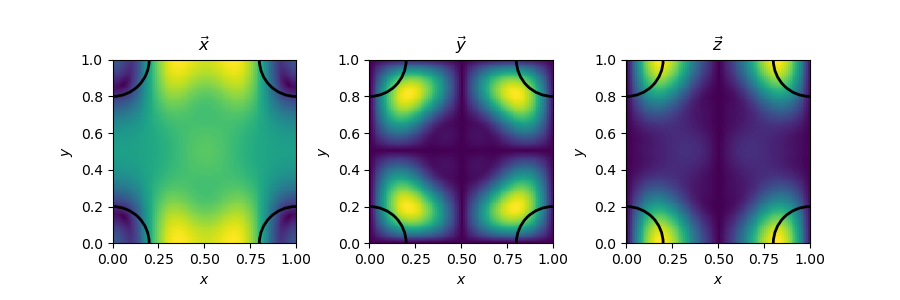

In [39]:
# create array to hold component labels
title_arr = ["x", "y", "z"]
# create plot
fig = plt.figure(figsize=(9, 3))
cnt = 1
for j in range(3):
    # add the subplot
    ax = fig.add_subplot(1, 3, cnt)
    # show the image
    # note we use "lower" to ensure the origin is in the lower left
    # rather than the upper left
    # we also explicitly set the extent, or the domain of
    # the x and y coordinates
    ax.imshow(np.abs(e_field_plane[:,:,j]),
              origin="lower",
              extent=[0, Lx, 0, Ly])
    # create an array to hold all the centers of the cylinders
    # we do this in this way to account for the periodic boundary conditions
    # we will come back to this in a bit to show how we can alter this
    # also note I am using list comprehension split over multiple
    # lines for readability
    p_centers = [np.array(centers[i]) + np.array(d)
                 for d in product([0.0, Lx], [0.0, Ly])
                 for i in range(len(centers))]
    # this is a bit cumbersome but it seems to work just fine
    title_str = "\\vec{" +  title_arr[j] + "}"
    ax.set_title("${}$".format(title_str))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    # draw the circles
    for center in p_centers:
        l_circle = plt.Circle(center, r, fill=False, edgecolor="k", linewidth=2)
        ax.add_artist(l_circle)
    # increment the count to move to the next subplot
    cnt += 1
plt.subplots_adjust(wspace=0.4)
plt.show()

and it looks the same as before. Excellent.

### Now we validate by reshaping the wrong way

In [40]:
# set up device geometry
# lattice spacing
Lx = 1.0
Ly = 1.0
# radius and center
r = 0.2
x0 = 0.0
y0 = 0.0
# create the simulation object
S = create_simulation(Lx, Ly, r, x0, y0)
# define the centers of our metasurface
centers = [[x0, y0]]
radii = [r for _ in centers]
create_circles(S, "Slab", "Silicon", centers, radii)
# set the simulation parameters
z = 0.0
n_x = 100
n_y = 200
# obtain the electric and magnetic fields
e_field_plane, h_field_plane = S.get_field_plane(z, (n_x, n_y))
# reshape into the correct array size (it is returned "flat")
# so n_y * n_x * 3 -> (n_y, n_x, 3)
e_field_plane = e_field_plane.reshape((n_x, n_y, 3))
h_field_plane = h_field_plane.reshape((n_x, n_y, 3))

<IPython.core.display.Javascript object>


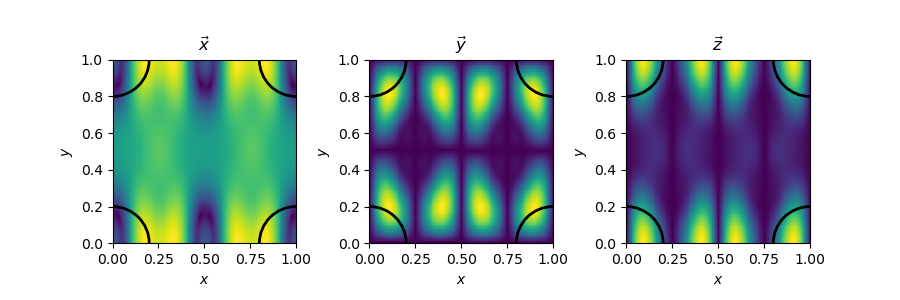

In [41]:
# create array to hold component labels
title_arr = ["x", "y", "z"]
# create plot
fig = plt.figure(figsize=(9, 3))
cnt = 1
for j in range(3):
    # add the subplot
    ax = fig.add_subplot(1, 3, cnt)
    # show the image
    # note we use "lower" to ensure the origin is in the lower left
    # rather than the upper left
    # we also explicitly set the extent, or the domain of
    # the x and y coordinates
    ax.imshow(np.abs(e_field_plane[:,:,j]),
              origin="lower",
              extent=[0, Lx, 0, Ly])
    # create an array to hold all the centers of the cylinders
    # we do this in this way to account for the periodic boundary conditions
    # we will come back to this in a bit to show how we can alter this
    # also note I am using list comprehension split over multiple
    # lines for readability
    p_centers = [np.array(centers[i]) + np.array(d)
                 for d in product([0.0, Lx], [0.0, Ly])
                 for i in range(len(centers))]
    # this is a bit cumbersome but it seems to work just fine
    title_str = "\\vec{" +  title_arr[j] + "}"
    ax.set_title("${}$".format(title_str))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    # draw the circles
    for center in p_centers:
        l_circle = plt.Circle(center, r, fill=False, edgecolor="k", linewidth=2)
        ax.add_artist(l_circle)
    # increment the count to move to the next subplot
    cnt += 1
plt.subplots_adjust(wspace=0.4)
plt.show()

And now it looks different. We have thus validated our datastructure and what S4 passes back.

# Periodicity and Periodic Boundary Conditions <a class="anchor" id="PBC"></a>

Recall that S$^4$ simulates structures that are periodic in $x$ and $y$, but are not periodic in $z$. Put another way, these structures are *infinite* in $x$ and $y$, but finite in $z$. We thus must deal with the periodicity, and we may choose to do so in any way we choose. We'll start with a simple example below

## A simple metasurface prepared three ways

Let's start by running the code below and viewing the output.

In [42]:
# set up device geometry
# lattice spacing
Lx = 1.0
Ly = 1.0
# radius and center
r = 0.2
x0 = 0.0
y0 = 0.0
# create the simulation object
S = create_simulation(Lx, Ly, r, x0, y0)
# define the centers of our metasurface
centers_0 = [[x0, y0]]
radii = [r for _ in centers_0]
create_circles(S, "Slab", "Silicon", centers_0, radii)
# set the simulation parameters
z = 0.0
n_x = 200
n_y = 200
# obtain the electric and magnetic fields
e_field_plane, h_field_plane = S.get_field_plane(z, (n_x, n_y))
# reshape into the correct array size (it is returned "flat")
# so n_y * n_x * 3 -> (n_y, n_x, 3)
e_field_plane_0 = np.copy(e_field_plane.reshape((n_y, n_x, 3)))
h_field_plane_0 = np.copy(h_field_plane.reshape((n_y, n_x, 3)))

e_field_plane_1 = np.copy(np.roll(np.roll(e_field_plane_0, n_x//2, axis=1), n_y//2, axis=0))
h_field_plane_1 = np.copy(np.roll(np.roll(h_field_plane_0, n_x//2, axis=1), n_y//2, axis=0))

S = create_simulation(Lx, Ly, r, x0, y0)
# define the centers of our metasurface
centers_2 = [[x0 + (Lx / 2), y0  + (Ly / 2)]]
radii = [r for _ in centers_2]
create_circles(S, "Slab", "Silicon", centers_2, radii)
# set the simulation parameters
z = 0.0
n_x = 200
n_y = 200
# obtain the electric and magnetic fields
e_field_plane, h_field_plane = S.get_field_plane(z, (n_x, n_y))
# reshape into the correct array size (it is returned "flat")
# so n_y * n_x * 3 -> (n_y, n_x, 3)
e_field_plane_2 = np.copy(e_field_plane.reshape((n_y, n_x, 3)))
h_field_plane_2 = np.copy(h_field_plane.reshape((n_y, n_x, 3)))

<IPython.core.display.Javascript object>


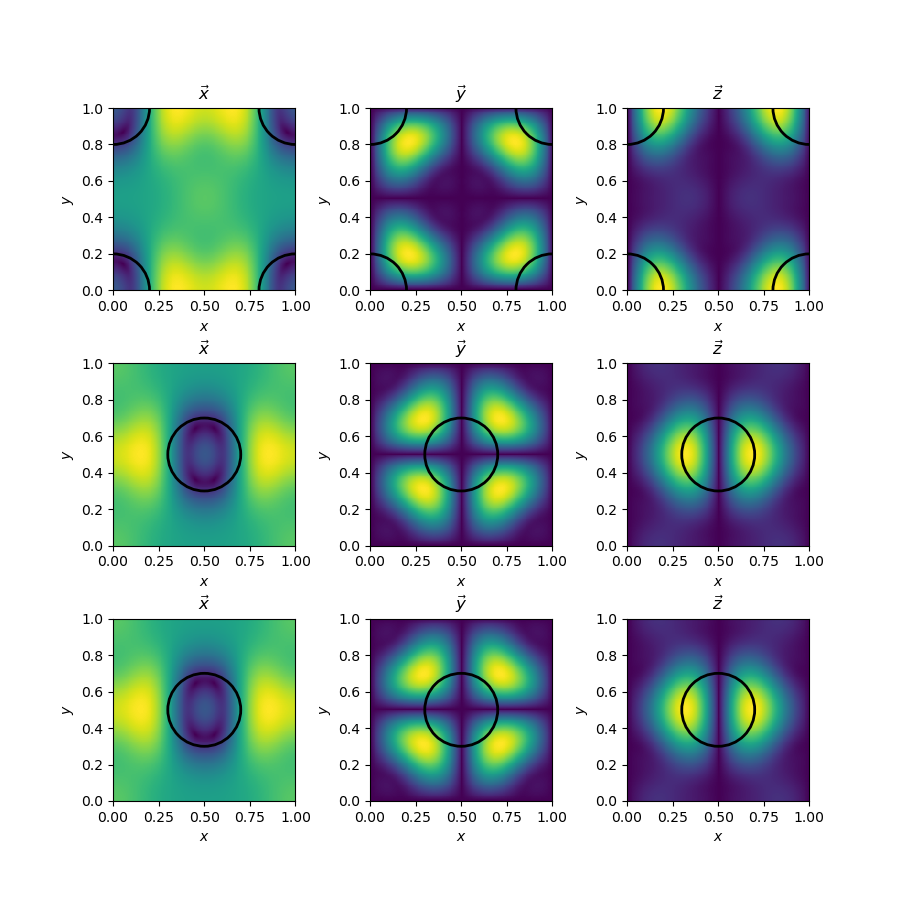

In [46]:
# create array to hold component labels
title_arr = ["x", "y", "z"]
# create plot
fig = plt.figure(figsize=(9, 9))
field_arr = [e_field_plane_0, e_field_plane_1, e_field_plane_2]
centers_arr = [centers_0, centers_2, centers_2]
cnt = 1
for i in range(3):
    l_field = field_arr[i]
    l_centers = centers_arr[i]
    for j in range(3):
        # add the subplot
        ax = fig.add_subplot(3, 3, cnt)
        # show the image
        # note we use "lower" to ensure the origin is in the lower left
        # rather than the upper left
        # we also explicitly set the extent, or the domain of
        # the x and y coordinates
        ax.imshow(np.abs(l_field[:,:,j]),
                  origin="lower",
                  extent=[0, Lx, 0, Ly])
        # create an array to hold all the centers of the cylinders
        # we do this in this way to account for the periodic boundary conditions
        # we will come back to this in a bit to show how we can alter this
        # also note I am using list comprehension split over multiple
        # lines for readability
        p_centers = [np.array(l_centers[p]) + np.array(d)
                     for d in product([0.0, Lx], [0.0, Ly])
                     for p in range(len(l_centers))]
        # this is a bit cumbersome but it seems to work just fine
        title_str = "\\vec{" +  title_arr[j] + "}"
        ax.set_title("${}$".format(title_str))
        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        # draw the circles
        for center in p_centers:
            l_circle = plt.Circle(center, r, fill=False, edgecolor="k", linewidth=2)
            ax.add_artist(l_circle)
        # increment the count to move to the next subplot
        cnt += 1
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

## Are these plots the same? Or are they different? <a class="anchor" id="exercise"></a>

Obviously the first row is different thant the second two, and the second and third rows look the same, but that doesn't actually answer the question. Let's look deeper. If you have any experience with crystallography, you'll know the answer, but we'll walk through it here. Let's make a few observations.

1. The first row has four quarter circles at the corners
2. The second row has a single circle in the center
3. The third row is the same as the second

**Each set of plots has a total of a single circle:** 1 full circle = 4 quarter circles. Thus, each row is showing *one primitive unit cell*. This is the first indication that perhaps all three rows show the same thing.

Let's now look at the code that produced these plots

### Row 1

```python
...
centers_0 = [[x0, y0]]
...
create_circles(S, "Slab", "Silicon", centers_0, radii)
...
e_field_plane, h_field_plane = S.get_field_plane(z, (n_x, n_y))
```

### Row 2

```python
e_field_plane_1 = np.copy(np.roll(np.roll(e_field_plane_0, n_x//2, axis=1), n_y//2, axis=0))
h_field_plane_1 = np.copy(np.roll(np.roll(h_field_plane_0, n_x//2, axis=1), n_y//2, axis=0))
```

### Row 3

```python
centers = [[x0 + (Lx / 2), y0  + (Ly / 2)]]
...
create_circles(S, "Slab", "Silicon", centers_2, radii)
...
e_field_plane, h_field_plane = S.get_field_plane(z, (n_x, n_y))
```

Row 1 puts a cylinder at $\left[0.0, 0.0\right]$ while Row 3 has a cylinder at $\left[0.5, 0.5\right]$. Row 2 is a bit trickier. Let's look at what `np.roll` actually does

<IPython.core.display.Javascript object>


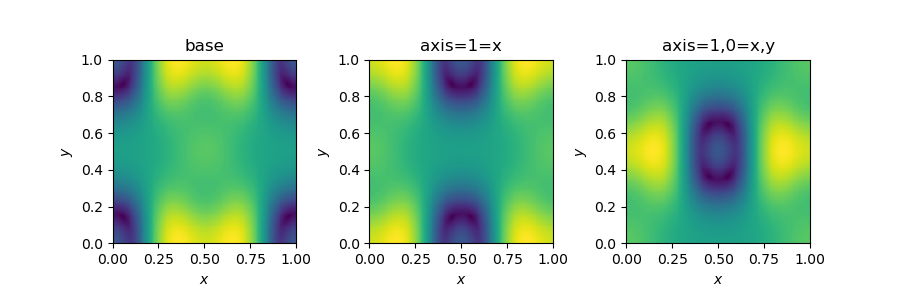

In [48]:
# create array to hold component labels
title_arr = ["base", "axis=1=x", "axis=1,0=x,y"]
# create plot
# create 3 different fields to plot
field_arr = list()
field_arr.append(np.copy(e_field_plane_0))
field_arr.append(np.copy(np.roll(e_field_plane_0, n_x//2, axis=1)))
field_arr.append(np.copy(np.roll(np.roll(e_field_plane_0, n_x//2, axis=1), n_y//2, axis=0)))
fig = plt.figure(figsize=(9, 3))
cnt = 1
for j in range(3):
    l_field = field_arr[j]
    # add the subplot
    ax = fig.add_subplot(1, 3, cnt)
    # show the image
    # note we use "lower" to ensure the origin is in the lower left
    # rather than the upper left
    # we also explicitly set the extent, or the domain of
    # the x and y coordinates
    ax.imshow(np.abs(l_field[:,:,0]),
              origin="lower",
              extent=[0, Lx, 0, Ly])
    # this is a bit cumbersome but it seems to work just fine
    title_str = title_arr[j]
    ax.set_title("{}".format(title_str))
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    # increment the count to move to the next subplot
    cnt += 1
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

Note how by using the `np.roll` command we can effectively shift the array by any amount, in this case by $n_x / 2 \rightarrow 0.5$. Thus, simulating a circle with a center of $\left[0.0, 0.0\right]$ is the same as simulating a circle of $\left[0.5, 0.5\right]$ as long as care is taken to account for the location of the origin.